In [ ]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class Config():
    training_dir = "/content/drive/MyDrive/Seg_Caltech101/Train/"
    gallary_dir = "/content/drive/MyDrive/Seg_Caltech101/Test/"
    query_dir="/content/drive/MyDrive/Seg_Caltech101/Query/"
    train_batch_size = 16
    train_number_epochs = 5

In [ ]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)), img0_tuple[1], img1_tuple[1]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [ ]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [ ]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

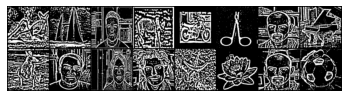

[54 55  0  2  3 80  1 46]
[54  1  0  1 86 60  1 84]
[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [ ]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[3].numpy())
print(example_batch[4].numpy())
print(example_batch[2].numpy())

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
#Declare optimizer with learning rate=0.0005 
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.1975996494293213

Epoch number 0
 Current loss 5.144441604614258

Epoch number 0
 Current loss 7.695221900939941

Epoch number 0
 Current loss 0.7771739959716797

Epoch number 0
 Current loss 3.941972255706787

Epoch number 0
 Current loss 1.016291618347168

Epoch number 0
 Current loss 4.1696600914001465

Epoch number 0
 Current loss 2.956507682800293

Epoch number 0
 Current loss 1.1850650310516357

Epoch number 0
 Current loss 2.796764373779297

Epoch number 0
 Current loss 1.838580846786499

Epoch number 0
 Current loss 1.1590263843536377

Epoch number 0
 Current loss 2.629420280456543

Epoch number 0
 Current loss 1.4969446659088135

Epoch number 0
 Current loss 1.2517863512039185

Epoch number 0
 Current loss 1.7899346351623535

Epoch number 0
 Current loss 21.12892723083496

Epoch number 0
 Current loss 1.1020934581756592

Epoch number 0
 Current loss 0.6969839334487915

Epoch number 0
 Current loss 1.0979764461517334

Epoch number 0
 Current loss 

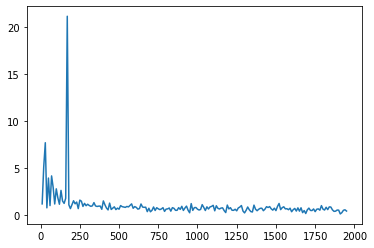

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , same, label0, label1 = data
        img0, img1 , same, label0, label1 = img0.cuda(), img1.cuda() , same.cuda(), label0.cuda(), label1.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,same)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)

In [ ]:
data_transforms =transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
train_data = torchvision.datasets.ImageFolder(
    root=Config.query_dir,
    transform= data_transforms
)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=None,
    num_workers=0,
    shuffle=False
)
test_data = torchvision.datasets.ImageFolder(
    root = Config.gallary_dir,
    transform = data_transforms
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=None,
    num_workers=1,
    shuffle=False
)

FileNotFoundError: ignored

In [ ]:
import csv
query_no=1
folder_dataset_query = dset.ImageFolder(root=Config.query_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_query,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
query_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=False)
#query_dataiter=iter(query_dataloader)
query_dataiter1=iter(train_loader)

#x0,_,_ = dataiter.next()
with open('/content/drive/MyDrive/Caltech101/Siamase_color_Qry.csv', 'w', newline='') as file:
  for data_query in (query_dataiter1):
    folder_dataset_test = dset.ImageFolder(root=Config.gallary_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                            transform=transforms.Compose([transforms.Resize((100,100)),
                                                                          transforms.ToTensor()
                                                                          ])
                                          ,should_invert=False)

    test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=False)
    #dataiter = iter(test_dataloader)
    dataiter1=iter(test_loader)
    #x0,_,label1,l0,l1 = data_query
    x0,l0= data_query
    #print(label1.numpy())
    #x0=data_query[0]
    #x0_label=label1[0].tolist()
    #x0_label=str(x0_label[0])
    #print(l0)
    for data in (dataiter1):
      #_,x1,label2,ll0,ll1 = data
      x1,ll1=data
      #x1=data[0]
      concatenated = torch.cat((x0,x1),0)
      output1,output2 = net(Variable(x0).unsqueeze(0).cuda(),Variable(x1).unsqueeze(0).cuda())
      euclidean_distance = F.pairwise_distance(output1, output2)
      #Newly Added
      x = []
      #np.array([[x.append(l0.numpy()[0])], [x.append(ll0.numpy()[0])], [x.append(euclidean_distance.cpu().detach().numpy()[0])]])
      np.array([[x.append(query_no)], [x.append(l0)], [x.append(ll1)], [x.append(euclidean_distance.cpu().detach().numpy()[0])]])
      x=np.array(x)
      x_csv=x.reshape(int(len(x)/4),4)
      ##print(x_csv)
      #print(l0)
      #..............#
      #print("Query image {}\n Test image {}\n Current loss {}\n".format(l0,ll0,euclidean_distance.item()))
      #print('Dissimilarity:'x0,x1,format(euclidean_distance.item()))
      #imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
      writer = csv.writer(file, delimiter=',')
      writer.writerows(x_csv) 
    query_no+=1 

In [ ]:
import csv
import pandas as pd
import numpy as np
from numpy import savetxt
q_no=0
data=pd.read_csv('/content/drive/MyDrive/file_name_o.csv',header=None)
#data= data.sort_values([0,2],ascending=[True,True])
data=np.array(data)
#print(data[:,0])
#print(data)
no_query=np.max(data[:,0])
#print(no_query)
top=[1,5,10,15,20]
for i in top:
  sum=0
  accuracy=0
  for q_no in range(46):
    data1=data[data[:,1]==q_no]
    data2=data1[data1[:,3].argsort()]
    #print(data1[:,3])
    #print(data2)
    #savetxt("/content/drive/MyDrive/Siamase_Output/output_sorted.txt", data1, newline=" ")
    #print(data1)
    data3=data2[0:i]
    #print(data3)
    data4=data3[data3[:,2]==q_no]
    #print(len(data4))
    no_match_data=len(data4)
    if(no_match_data==0):
      no_match_data=0
    else:
      no_match_data=1
      sum+=1
    #print(no_match_data)
    q_no+=1
  #print(sum)
  #print(q_no)
  acc=(sum/q_no)*100
  print("Top %d accuracy="%i,acc)

In [ ]:
import csv
import pandas as pd
import numpy as np
from numpy import savetxt
q_no=0
data=pd.read_csv('/content/drive/MyDrive/file_name_o.csv',header=None)
#data= data.sort_values([0,2],ascending=[True,True])
data=np.array(data)
#print(data[:,0])
#print(data)
no_query=np.max(data[:,0])
#print(no_query)
top=[1,5,10,15,20]
for i in top:
  sum=0
  accuracy=0
  for q_no in range(46):
    data1=data[data[:,0]==q_no]
    data2=data1[data1[:,2].argsort()]
    #print(data1[:,3])
    #print(data2)
    #savetxt("/content/drive/MyDrive/Siamase_Output/output_sorted.txt", data1, newline=" ")
    #print(data1)
    data3=data2[0:i]
    #print(data3)
    data4=data3[data3[:,1]==q_no]
    #print(len(data4))
    no_match_data=len(data4)
    if(no_match_data==0):
      no_match_data=0
    else:
      no_match_data=1
      sum+=1
    #print(no_match_data)
    q_no+=1
  #print(sum)
  #print(q_no)
  acc=(sum/q_no)*100
  print("Top %d accuracy="%i,acc)

Top 1 accuracy= 6.521739130434782
Top 5 accuracy= 26.08695652173913
Top 10 accuracy= 36.95652173913043
Top 15 accuracy= 50.0
Top 20 accuracy= 60.86956521739131


In [ ]:
# Weighted Late Fuse###
import csv
import pandas as pd
import numpy as np
from numpy import savetxt
i=1
with open('/content/drive/MyDrive/1.csv', 'w', newline='') as file:
  data1=pd.read_csv('/content/drive/MyDrive/Splitted color shoe/Color_Qry_1.csv',header=None)
  data2=pd.read_csv('/content/drive/MyDrive/Splitted Segmented Shoe/Segment_Qry_1.csv',header=None)
  x=data1
  x[3] = (data1[3] + data2[3])/2
  #x[3] = (0.6*(data1[3]) + 0.4*(data2[3]))/2
  print(x)
  x.to_csv('/content/drive/MyDrive/1.csv')

           0     1     2         3
0        1.0   0.0   0.0  0.157697
1        1.0   0.0   0.0  0.667763
2        1.0   0.0   0.0  0.307749
3        1.0   0.0   0.0  0.476061
4        1.0   0.0   0.0  0.746594
...      ...   ...   ...       ...
130981  19.0  18.0  17.0       NaN
130982  19.0  18.0  17.0       NaN
130983  19.0  18.0  17.0       NaN
130984  19.0  18.0  18.0       NaN
130985  19.0  18.0  18.0       NaN

[130986 rows x 4 columns]
